# IEEE Fraud Detection : Part 02:
Data pre-processing steps

In [1]:
import os
import gc
gc.enable()
import time

import numpy as np 
import pandas as pd 

import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.simplefilter("ignore")

In [2]:
# train_data = pd.read_csv(os.getcwd() + '\\Data\\train.csv')
train_data = pd.read_parquet(os.getcwd() + '\\Data\\train.gzip')

In [3]:
# Only load for prediction or later for manipulaiton:
# test_data = pd.read_parquet(os.getcwd() + '\\Data\\test.gzip')

In [4]:
train_data.info()
#test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 590540 entries, 0 to 590539
Columns: 433 entries, isFraud to DeviceInfo
dtypes: float64(80), int64(322), object(31)
memory usage: 1.9+ GB


# Column Definitions:

| Column Names | Description |
| --- | --- |
| TransactionDT | timedelta from a given reference datetime (not an actual timestamp) |
| TransactionAMT | transaction payment amount in USD |
| ProductCD | product code, the product for each transaction |
| card1 - card6 | payment card information, such as card type, card category, issue bank, country, etc. |
| addr_ | address |
| dist | distance |
| P_ and (R__) emaildomain | purchaser and recipient email domain |
| C1-C14 | counting, such as how many addresses are found to be associated with the payment card, etc. The actual meaning is masked. |
| D1-D15 | timedelta, such as days between previous transaction, etc. |
| M1-M9 | match, such as names on card and address, etc. |
| Vxxx | Vesta engineered rich features, including ranking, counting, and other entity relations. |

Categorical Features: ProductCD, card1 - card6, addr1, addr2, P_emaildomain, R_emaildomain, M1 - M9, DeviceType, DeviceInfo, id_12 - id_38

Rest of the variables (DeviceType, DeviceInfo, id_12 - id_38, etc.) are identity information – network connection information (IP, ISP, Proxy, etc) and digital signature (UA/browser/os/version, etc) associated with transactions. 

They're collected by Vesta’s fraud protection system and digital security partners.
(The field names are masked and pairwise dictionary will not be provided for privacy protection and contract agreement)


In [5]:
# Finding out the class proportion to determine class Imbalance.

def class_prop_binary(df, trg = 'isFraud'):
    """
    df = pandas dataframe of the dataset to determine class proportion
    trg = the column name in string format
    """
    print("The minority class count: {}".format(sum(df[trg]==1)))
    print("The majority class count: {}".format(sum(df[trg]==0)))
    print("The class proportion:")
    print("Yes : No =  {} : {}".format(round(sum(df[trg]==1)/df[trg].shape[0],3),round(sum(df[trg]==0)/df[trg].shape[0],3)))
   
class_prop_binary(train_data)
print("Highly Imbalanced data set")

The minority class count: 20663
The majority class count: 569877
The class proportion:
Yes : No =  0.035 : 0.965
Highly Imbalanced data set


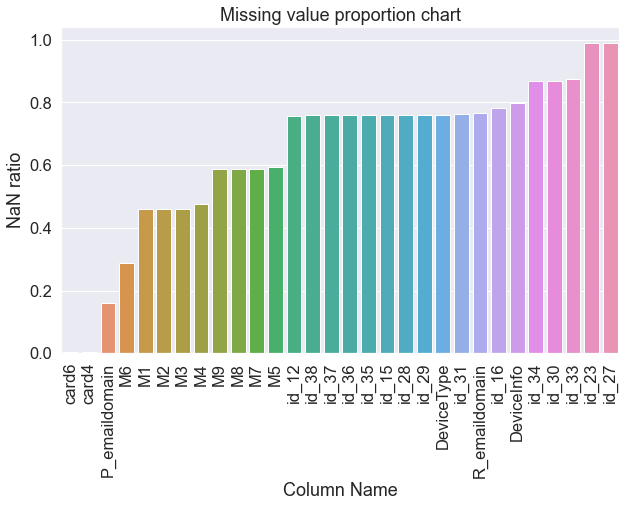

In [6]:
# train_data = pd.read_csv(os.getcwd() + '\\Data\\train.csv')

def missing_value_bars(df):
    missing_values = df.isna().sum() / len(df)
    missing_values = missing_values[missing_values > 0]
    missing_values.sort_values(inplace=True)

    missing_values = missing_values.to_frame()
    missing_values.columns = ['count']
    missing_values.index.names = ['Name']
    missing_values['Name'] = missing_values.index

    # missing_values

    sns.set(style="darkgrid", color_codes=True, font_scale = 1.5)
    fig, ax = plt.subplots(figsize=(10, 6))
    l1 = sns.barplot(ax = ax, x = 'Name', y = 'count', data=missing_values)
    l1.set(title='Missing value proportion chart', xlabel='Column Name', ylabel='NaN ratio')
    plt.xticks(rotation = 90)
    plt.show()
    return missing_values['Name'].values


missing_value_columns = missing_value_bars(train_data)


In [7]:
# Decided to Drop the missing value features for convenience of memory 
train_data.drop(axis = 1, columns=missing_value_columns, inplace = True)
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 590540 entries, 0 to 590539
Columns: 403 entries, isFraud to id_32
dtypes: float64(80), int64(322), object(1)
memory usage: 1.8+ GB


In [8]:
# sample_train = train_data.sample(frac=0.05, replace=False, random_state=1).reset_index(drop=True)
# del train_data
# sample_train
# class_prop_binary(sample_train)
# sample_train.iloc[:, 0:20] 

In [9]:
# Only for testing:

# train_data.loc[:, ['isFraud','TransactionAmt','addr1', 'addr2', 'dist1', 'dist2']].head(10)

# train_data.loc[:,train_data.columns[train_data.columns.str.contains("card")]].head(10)
# train_data['card2'].unique()

# train_data.loc[:,train_data.columns[train_data.columns.str.contains("C")]].head(10)
# train_data.loc[:,train_data.columns[train_data.columns.str.contains("D")]].head(10)
# train_data.loc[:,train_data.columns[train_data.columns.str.contains("V")]].head(10)

# train_data.loc[:,train_data.columns[train_data.columns.str.contains("id_")]].head(10)
# train_data['id_21'].unique()


In [10]:
# train_data.loc[:,train_data.columns[train_data.columns.str.contains("M")]].head(10)
# The M_ columns were deleted due to missing values.

## Planning Next steps:

### Feature engineering:

- Decide on which categorical columns are important and Use one hot encoding for all categorical columns. After that use PCA to get reduced variables.
- Decide on which Vxxx, id_xx, Cx, Dx, columns are important; get rid of the highly correlated ones for each groups. After that use PCA to get reduced variables for each groups.
- Try to get unique customer id from addr1, addr2, email domains, dist, etc.
- Try to get an approximate timeseries from interpreting TransactionDT
- Try to get TimeofDay from columns Dxx

### Testing ML models with Sample dataset:

- sample and filter out a subset with similar class proportion with just numeric variables.
- test with Logistic Regression, SVC, Random forest, LGB, XGB.
- find out weakness and strength of the above algorithms.
- Use AUC, Precision/Recall, and Confusion matrix to evaluate.

### Handling class imbalance/skewness:

- Try Undersampling Majority Class.
- Try SMOTE
- Try weight-assigning in XGB or LGB

In [11]:
# Categorical Features: ProductCD, card1 - card6, addr1, addr2, P_emaildomain, R_emaildomain, M1 - M9, DeviceType, DeviceInfo, id_12 - id_38

cat_vars = ['ProductCD', 'card1', 'card2', 'card3', 'card5', 'addr1', 'addr2', 'id_13', 'id_14', 'id_17', 'id_18', 'id_19', 'id_20','id_21', 'id_22', 'id_24', 'id_25', 'id_26', 'id_32']
num_vars = list(set(train_data.columns) - set(cat_vars))
train_data_num = train_data.loc[:,num_vars]
train_data_num.drop(axis = 1, columns='TransactionDT', inplace = True)
num_vars = train_data_num.columns
train_data_num.head(10)

,V44,V174,V11,V85,V240,V251,V228,V315,V104,V227,...,V36,V113,V75,V320,V291,V167,V127,V164,V243,V145
0,255,255,0,0,255,255,255,0.0,0,65535,...,255,1,1,0.0,1,65535,117.0,-1.0,255,65535
1,1,255,255,0,255,255,255,0.0,0,65535,...,0,1,0,0.0,1,65535,0.0,-1.0,255,65535
2,1,255,0,0,255,255,255,0.0,0,65535,...,1,1,1,0.0,1,65535,0.0,-1.0,255,65535
3,1,255,255,0,255,255,255,0.0,0,65535,...,1,1,1,0.0,1,65535,1758.0,-1.0,255,65535
4,255,0,255,255,1,1,1,0.0,0,0,...,255,1,255,0.0,1,0,0.0,515.0,1,140
5,1,255,0,0,255,255,255,0.0,0,65535,...,1,1,1,0.0,1,65535,0.0,-1.0,255,65535
6,1,255,0,0,255,255,255,0.0,0,65535,...,1,1,1,0.0,1,65535,0.0,-1.0,255,65535
7,1,255,255,0,255,255,255,0.0,0,65535,...,0,1,0,0.0,1,65535,0.0,-1.0,255,65535
8,255,0,255,255,1,1,1,0.0,0,0,...,255,1,255,0.0,1,0,0.0,515.0,1,140
9,1,255,0,0,255,255,255,0.0,0,65535,...,1,1,1,0.0,1,65535,0.0,-1.0,255,65535


In [12]:
train_data_num.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 590540 entries, 0 to 590539
Columns: 383 entries, V44 to V145
dtypes: float64(80), int64(303)
memory usage: 1.7 GB


In [13]:
train_data_cat = train_data.loc[:,cat_vars]
train_data_cat

,ProductCD,card1,card2,card3,card5,addr1,addr2,id_13,id_14,id_17,id_18,id_19,id_20,id_21,id_22,id_24,id_25,id_26,id_32
0,W,13926,99,150,142,315,87,9,-661,99,9,99,99,99,9,10,99,99,255
1,W,2755,404,150,102,325,87,9,-661,99,9,99,99,99,9,10,99,99,255
2,W,4663,490,150,166,330,87,9,-661,99,9,99,99,99,9,10,99,99,255
3,W,18132,567,150,117,476,87,9,-661,99,9,99,99,99,9,10,99,99,255
4,H,4497,514,150,102,420,87,9,-480,166,9,542,144,99,9,10,99,99,32
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
590535,W,6550,99,150,226,272,87,9,-661,99,9,99,99,99,9,10,99,99,255
590536,W,10444,225,150,224,204,87,9,-661,99,9,99,99,99,9,10,99,99,255
590537,W,12037,595,150,224,231,87,9,-661,99,9,99,99,99,9,10,99,99,255
590538,W,7826,481,150,224,387,87,9,-661,99,9,99,99,99,9,10,99,99,255


In [14]:
# train_data_cat.info()
# train_data_cat['card1'].dtypestrain_data_cat['card1'].dtypes == 'int64'
# sum(train_data_cat.dtypes=='int64') total 18 integer and 1 objext type.
# Seems like the categorical features also have integer values. Need to convert to categoricals / objects.
train_data_cat = train_data_cat.astype('object')
train_data_cat.info()
del train_data

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 590540 entries, 0 to 590539
Data columns (total 19 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   ProductCD  590540 non-null  object
 1   card1      590540 non-null  object
 2   card2      590540 non-null  object
 3   card3      590540 non-null  object
 4   card5      590540 non-null  object
 5   addr1      590540 non-null  object
 6   addr2      590540 non-null  object
 7   id_13      590540 non-null  object
 8   id_14      590540 non-null  object
 9   id_17      590540 non-null  object
 10  id_18      590540 non-null  object
 11  id_19      590540 non-null  object
 12  id_20      590540 non-null  object
 13  id_21      590540 non-null  object
 14  id_22      590540 non-null  object
 15  id_24      590540 non-null  object
 16  id_25      590540 non-null  object
 17  id_26      590540 non-null  object
 18  id_32      590540 non-null  object
dtypes: object(19)
memory usage: 85.6+ MB


In [15]:
# Doing PCA for the numerical table: 

# Taking the id_vars_num and applying pca:
id_vars_num = ['id_01', 'id_02', 'id_03',
       'id_04', 'id_05', 'id_06', 'id_07', 'id_08', 'id_09', 'id_10',
       'id_11']
train_data_num_id = train_data_num.loc[:,id_vars_num]
train_data_num_id.head(10)


,id_01,id_02,id_03,id_04,id_05,id_06,id_07,id_08,id_09,id_10,id_11
0,-101,0,-14,-29,-73,-101,-47,-101,-37,-101,89.0
1,-101,0,-14,-29,-73,-101,-47,-101,-37,-101,89.0
2,-101,0,-14,-29,-73,-101,-47,-101,-37,-101,89.0
3,-101,0,-14,-29,-73,-101,-47,-101,-37,-101,89.0
4,0,70787,-14,-29,-73,-101,-47,-101,-37,-101,100.0
5,-101,0,-14,-29,-73,-101,-47,-101,-37,-101,89.0
6,-101,0,-14,-29,-73,-101,-47,-101,-37,-101,89.0
7,-101,0,-14,-29,-73,-101,-47,-101,-37,-101,89.0
8,-5,98945,-14,-29,0,-5,-47,-101,-37,-101,100.0
9,-101,0,-14,-29,-73,-101,-47,-101,-37,-101,89.0


In [16]:
def pca_num(df, exp_var = 0.95, rand = 10):    
    from sklearn import preprocessing
    from sklearn.decomposition import PCA

    x = df.values #returns a numpy array
    std_scaler = preprocessing.StandardScaler() 
    x_scaled = std_scaler.fit_transform(x) # standardizing the features
    # x_scaled
    print('Size of DF before PCA:')
    print(x_scaled.shape)
    from sklearn.decomposition import PCA
    pca_11 = PCA(n_components = exp_var, random_state = rand, svd_solver='auto') # Taking 95 % of the explained variables
    pca_11.fit(x_scaled)
    x_pca_11 = pca_11.transform(x_scaled)
    print('Size of DF after PCA:')
    print(x_pca_11.shape) # reduces 11 columns to only 4.
    # pca_11.explained_variance_ratio_ 
    return x_pca_11



In [17]:
df_id_num_pca = pd.DataFrame(pca_num(train_data_num_id))

a = pd.Series(df_id_num_pca.columns)
def addcolstr(x, name_str = 'id_num_pca'):
    x = name_str+str(x)
    return x

a = a.apply(addcolstr)
df_id_num_pca.columns = a.astype('str')
df_id_num_pca.columns
del train_data_num_id, a

df_id_num_pca.head(10)


Size of DF before PCA:
(590540, 11)
Size of DF after PCA:
(590540, 4)


,id_num_pca0,id_num_pca1,id_num_pca2,id_num_pca3
0,-1.365158,0.005713,-0.232065,0.049977
1,-1.365158,0.005713,-0.232065,0.049977
2,-1.365158,0.005713,-0.232065,0.049977
3,-1.365158,0.005713,-0.232065,0.049977
4,0.514245,-0.143025,1.380942,-0.447725
5,-1.365158,0.005713,-0.232065,0.049977
6,-1.365158,0.005713,-0.232065,0.049977
7,-1.365158,0.005713,-0.232065,0.049977
8,2.160078,-0.392058,2.745820,-1.297554
9,-1.365158,0.005713,-0.232065,0.049977


In [18]:
train_data_V_num = train_data_num.loc[:,train_data_num.columns[train_data_num.columns.str.contains("V")]]
train_data_V_num.head(10)
V_num_vars = train_data_V_num.columns

In [19]:
df_Vxx_num_pca = pd.DataFrame(pca_num(train_data_V_num))

a = pd.Series(df_Vxx_num_pca.columns)
def addcolstr(x, name_str = 'V_num_pca'):
    x = name_str+str(x)
    return x

a = a.apply(addcolstr)
df_Vxx_num_pca.columns = a.astype('str')
df_Vxx_num_pca.columns
del train_data_V_num, a
df_Vxx_num_pca.head(10)

Size of DF before PCA:
(590540, 339)
Size of DF after PCA:
(590540, 19)


,V_num_pca0,V_num_pca1,V_num_pca2,V_num_pca3,V_num_pca4,V_num_pca5,V_num_pca6,V_num_pca7,V_num_pca8,V_num_pca9,V_num_pca10,V_num_pca11,V_num_pca12,V_num_pca13,V_num_pca14,V_num_pca15,V_num_pca16,V_num_pca17,V_num_pca18
0,-5.152873,0.473725,1.520168,-4.198483,0.154020,-1.596747,5.028239,0.754020,-2.108591,-3.509991,0.031009,-0.316354,0.179024,-0.827322,1.285929,0.071911,-0.290227,0.379873,-0.448661
1,-5.958119,-0.413948,-0.296824,0.370553,-0.190419,-0.328112,-0.306337,-0.030477,1.532713,4.347042,-0.229934,-0.262286,-0.195172,-0.869899,0.957945,-0.331007,0.318478,0.299382,-0.281859
2,-6.997868,-0.338134,0.016775,-0.663237,-0.154841,0.431549,-2.181578,0.037155,-0.368679,-1.188345,-0.210495,0.063778,-0.281782,0.817373,0.529909,0.088098,0.186680,-0.068781,-0.188123
3,-5.999353,0.515325,0.397454,0.712364,0.661663,0.195181,-0.155648,-0.613732,1.314556,4.348871,0.184816,-0.076600,0.075968,-1.729273,-0.773878,-0.597132,0.306252,0.236538,2.455814
4,30.581000,-0.052506,0.751396,-5.440955,-0.109218,0.068354,-2.499463,0.649668,-0.051436,0.051791,5.564478,-9.932351,-0.758024,0.651833,-0.214771,0.166762,-0.677575,0.059457,0.178593
5,-6.997868,-0.338134,0.016775,-0.663237,-0.154841,0.431549,-2.181578,0.037155,-0.368679,-1.188345,-0.210495,0.063778,-0.281782,0.817373,0.529909,0.088098,0.186680,-0.068781,-0.188123
6,-6.997868,-0.338134,0.016775,-0.663237,-0.154841,0.431549,-2.181578,0.037155,-0.368679,-1.188345,-0.210495,0.063778,-0.281782,0.817373,0.529909,0.088098,0.186680,-0.068781,-0.188123
7,-5.958119,-0.413948,-0.296824,0.370553,-0.190419,-0.328112,-0.306337,-0.030477,1.532713,4.347042,-0.229934,-0.262286,-0.195172,-0.869899,0.957945,-0.331007,0.318478,0.299382,-0.281859
8,30.581457,-0.052486,0.751488,-5.441347,-0.109274,0.068479,-2.500144,0.649784,-0.051450,0.051805,5.567896,-9.939614,-0.758756,0.652204,-0.214835,0.166928,-0.678274,0.059148,0.178755
9,-7.017421,-0.282382,0.120738,-0.636365,-0.164171,0.548532,-2.162194,-0.062052,-0.421368,-1.168991,-0.189003,0.073625,-0.104418,0.521663,-0.532748,-0.030334,-0.192498,-0.241508,-0.965473


In [20]:
train_data_D_num = train_data_num.loc[:,train_data_num.columns[train_data_num.columns.str.contains("D")]]
train_data_D_num.head(10)
D_num_vars = train_data_D_num.columns

In [21]:
df_D_num_pca = pd.DataFrame(pca_num(train_data_D_num))

a = pd.Series(df_D_num_pca.columns)
def addcolstr(x, name_str = 'D_num_pca'):
    x = name_str+str(x)
    return x

a = a.apply(addcolstr)
df_D_num_pca.columns = a.astype('str')
df_D_num_pca.columns
del train_data_D_num, a
df_D_num_pca.head(10)

Size of DF before PCA:
(590540, 15)
Size of DF after PCA:
(590540, 11)


,D_num_pca0,D_num_pca1,D_num_pca2,D_num_pca3,D_num_pca4,D_num_pca5,D_num_pca6,D_num_pca7,D_num_pca8,D_num_pca9,D_num_pca10
0,0.139957,-1.156510,-0.753260,-0.689744,0.112277,0.376422,-0.322857,0.450302,-0.317564,-0.089996,0.023425
1,0.707978,-1.560376,-1.080826,0.394387,-0.228070,-0.186674,-0.015313,0.526510,-0.195404,0.305608,0.047552
2,-0.421755,-0.974412,-0.529682,1.701971,-0.523933,1.293545,-0.708551,0.157840,-0.705170,0.052222,0.167866
3,-1.228013,0.360126,0.036707,-1.133235,0.241330,-0.807506,0.446285,0.126732,0.226537,0.018421,0.012058
4,1.645848,-2.505205,0.076442,0.188545,-0.179242,-0.524062,-0.673885,-1.259183,0.777011,-0.507046,0.427039
5,0.612793,-1.525395,-1.030788,0.513607,-0.255384,-0.030141,-0.084355,0.471612,-0.305660,0.136978,0.060264
6,0.612793,-1.525395,-1.030788,0.513607,-0.255384,-0.030141,-0.084355,0.471612,-0.305660,0.136978,0.060264
7,0.707978,-1.560376,-1.080826,0.394387,-0.228070,-0.186674,-0.015313,0.526510,-0.195404,0.305608,0.047552
8,1.645848,-2.505205,0.076442,0.188545,-0.179242,-0.524062,-0.673885,-1.259183,0.777011,-0.507046,0.427039
9,-2.451139,1.141161,0.597599,0.454183,-0.170785,0.136993,0.100499,-0.263007,-0.077471,-0.411211,-0.030588


In [22]:
train_data_C_num = train_data_num.loc[:,train_data_num.columns[train_data_num.columns.str.contains("C")]]
train_data_C_num.head(10)
C_num_vars = train_data_C_num.columns

In [23]:
df_C_num_pca = pd.DataFrame(pca_num(train_data_C_num))

a = pd.Series(df_C_num_pca.columns)
def addcolstr(x, name_str = 'C_num_pca'):
    x = name_str+str(x)
    return x

a = a.apply(addcolstr)
df_C_num_pca.columns = a.astype('str')
df_C_num_pca.columns
del train_data_C_num, a
df_C_num_pca.head(10)

Size of DF before PCA:
(590540, 14)
Size of DF after PCA:
(590540, 3)


,C_num_pca0,C_num_pca1,C_num_pca2
0,-0.331272,-0.334273,-0.041043
1,-0.338282,-0.370772,-0.041321
2,-0.334589,-0.334193,-0.041046
3,-0.264718,-0.264662,-0.040293
4,-0.331892,-0.373663,-0.041333
5,-0.334589,-0.334193,-0.041046
6,-0.334589,-0.334193,-0.041046
7,-0.338282,-0.370772,-0.041321
8,-0.331892,-0.373663,-0.041333
9,-0.286864,-0.225701,-0.040102


In [24]:
rem_num_vars = (list(set(num_vars) - (set(id_vars_num) | set(V_num_vars) | set(D_num_vars) | set(C_num_vars))))
rem_num_vars

['isFraud', 'dist2', 'TransactionAmt', 'dist1']

In [30]:
train_data_num_rem = train_data_num.loc[:,rem_num_vars]
train_data_num_rem

,isFraud,dist2,TransactionAmt,dist1
0,0,65535,68.50,19
1,0,65535,29.00,65535
2,0,65535,59.00,287
3,0,65535,50.00,65535
4,0,65535,50.00,65535
...,...,...,...,...
590535,0,65535,49.00,48
590536,0,65535,39.50,65535
590537,0,65535,30.95,65535
590538,0,65535,117.00,3


In [31]:
target_var = train_data_num_rem[['isFraud']] 
train_data_num_rem.drop(axis = 1, columns='isFraud', inplace = True)
target_var

,isFraud
0,0
1,0
2,0
3,0
4,0
...,...
590535,0
590536,0
590537,0
590538,0


In [32]:
df_rem_num_pca = pd.DataFrame(pca_num(train_data_num_rem))

a = pd.Series(df_rem_num_pca.columns)
def addcolstr(x, name_str = 'rem_num_pca'):
    x = name_str+str(x)
    return x

a = a.apply(addcolstr)
df_rem_num_pca.columns = a.astype('str')
df_rem_num_pca.columns
del train_data_num_rem, a
df_rem_num_pca.head(10)

Size of DF before PCA:
(590540, 3)
Size of DF after PCA:
(590540, 3)


,rem_num_pca0,rem_num_pca1,rem_num_pca2
0,0.902533,-0.682364,0.592592
1,-0.492155,-0.172537,-0.817890
2,0.885349,-0.717028,0.580318
3,-0.466340,-0.089895,-0.803263
4,-0.466340,-0.089895,-0.803263
5,0.878213,-0.758930,0.578651
6,1.014173,-0.326411,0.656030
7,-0.008435,1.376008,-0.543804
8,-0.509364,-0.227631,-0.827642
9,0.962153,-0.491501,0.626374


In [33]:
pca_num_train = pd.concat([df_rem_num_pca, df_id_num_pca, df_C_num_pca, df_D_num_pca, df_Vxx_num_pca], axis=1)
del train_data_num
pca_num_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 590540 entries, 0 to 590539
Data columns (total 40 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   rem_num_pca0  590540 non-null  float64
 1   rem_num_pca1  590540 non-null  float64
 2   rem_num_pca2  590540 non-null  float64
 3   id_num_pca0   590540 non-null  float64
 4   id_num_pca1   590540 non-null  float64
 5   id_num_pca2   590540 non-null  float64
 6   id_num_pca3   590540 non-null  float64
 7   C_num_pca0    590540 non-null  float64
 8   C_num_pca1    590540 non-null  float64
 9   C_num_pca2    590540 non-null  float64
 10  D_num_pca0    590540 non-null  float64
 11  D_num_pca1    590540 non-null  float64
 12  D_num_pca2    590540 non-null  float64
 13  D_num_pca3    590540 non-null  float64
 14  D_num_pca4    590540 non-null  float64
 15  D_num_pca5    590540 non-null  float64
 16  D_num_pca6    590540 non-null  float64
 17  D_num_pca7    590540 non-null  float64
 18  D_nu

In [35]:
# Saving only numeric data to setup machine learning models. Plan to deal with categorical data later.
pca_num_train.to_parquet('pca_num_train.gzip', compression='gzip')
target_var.to_parquet('target_var.gzip', compression='gzip')